#### NOTE: Extended from `create_google_speech_trainer_configs.ipynb` 
Original code was in `examples/async_google_speech/trainer`. This is
the newer version which also adds support for CIFAR-10

### DATASET 1: Google Speech

In [31]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
from collections import defaultdict


In [2]:
LABEL_MAP = {
    'backward': 0,
    'bed': 1,
    'bird': 2,
    'cat': 3,
    'dog': 4,
    'down': 5,
    'eight': 6,
    'five': 7,
    'follow': 8,
    'forward': 9,
    'four': 10,
    'go': 11,
    'happy': 12,
    'house': 13,
    'learn': 14,
    'left': 15,
    'marvin': 16,
    'nine': 17,
    'no': 18,
    'off': 19,
    'on': 20,
    'one': 21,
    'right': 22,
    'seven': 23,
    'sheila': 24,
    'six': 25,
    'stop': 26,
    'three': 27,
    'tree': 28,
    'two': 29,
    'up': 30,
    'visual': 31,
    'wow': 32,
    'yes': 33,
    'zero': 34
}

In [32]:
def create_dirichlet_splits(dataset: Dataset, num_trainers: int, alpha: float) -> dict:
    """
    Create splits of dataset indices according to a Dirichlet distribution.

    Args:
        dataset (Dataset): The dataset to split.
        num_trainers (int): The number of trainers.
        alpha (float): The alpha value for the Dirichlet distribution.

    Returns:
        dict: A dictionary mapping each trainer ID to a list of dataset indices.
    """
    labels = [label for _, _, label, _, _ in dataset]  # Assuming the third element is the label
    labels = np.array([LABEL_MAP[label] for label in labels])  # Convert labels to integers
    
    num_classes = len(np.unique(labels))
    label_distribution = defaultdict(list)

    # Collect indices for each class
    for idx, label in enumerate(labels):
        label_distribution[label].append(idx)

    # Create Dirichlet distribution splits
    trainer_indices = defaultdict(list)
    for label, indices in label_distribution.items():
        proportions = np.random.dirichlet([alpha] * num_trainers)
        proportions = (proportions * len(indices)).astype(int)
        np.random.shuffle(indices)
        start_idx = 0
        for i, count in enumerate(proportions):
            trainer_indices[i].extend(indices[start_idx:start_idx + count])
            start_idx += count

    return trainer_indices

In [19]:
# Example usage
if __name__ == "__main__":
    dataset = SPEECHCOMMANDS('./data', download=True, subset='training')
    num_trainers = 300
    alpha = 0.1
    trainer_indices = create_dirichlet_splits(dataset, num_trainers, alpha)
    print(trainer_indices)

defaultdict(<class 'list'>, {0: [6293, 5467, 5812, 5712, 4719, 4681, 6073, 6185, 4903, 5132, 5206, 5988, 5320, 5279, 7401, 25943, 24701, 23725, 23190, 25268, 25842, 24565, 24695, 25655, 25115, 23954, 24039, 24965, 24839, 25359, 25533, 24204, 25995, 24387, 24090, 25581, 24734, 25014, 23323, 23987, 24536, 25816, 23293, 25915, 23215, 25651, 23254, 24376, 24960, 23007, 25496, 24413, 23892, 25283, 25957, 23058, 25521, 25249, 25490, 24176, 23500, 24493, 24172, 25435, 22920, 22900, 25566, 23788, 23683, 23203, 25530, 23468, 23543, 24806, 52647, 51044, 53210, 53867, 53097, 52688, 51862, 51377, 52983, 52240, 52839, 51178, 53666, 51675, 53902, 51060, 51318, 52001, 53629, 53319, 51186, 53557, 52303, 51964, 52494, 51062, 53519, 51694, 51856, 52562, 53387, 52348, 58228, 58186, 57981, 58157, 58067, 57750, 57605, 58705, 57990, 64469, 62640, 63467, 63928, 64317, 63365, 64271, 63131, 62415, 63155, 64589, 62608, 62844, 61936, 64243, 64201, 63524, 63619, 63991, 63805, 64685, 64637, 62380, 63987, 63460, 63

In [21]:
len(trainer_indices[24])

202

##### UPDATE TRAINER CONFIG with new trainer_indices_list

In [112]:
import json
import os

def update_trainer_indices_list(directory_path, trainer_indices):
    """
    Update the 'trainer_indices' property in each JSON file in the specified directory.

    Parameters:
    - directory_path (str): The path to the directory containing JSON files.
    - new_value (str): The new value for the 'trainer_indices_list' property.

    Returns:
    - None
    """
    # Loop through all files in the directory
    trainer_counter = 0
    for filename in os.listdir(directory_path):
        if filename.endswith(".json") and filename.startswith("trainer_"):
            file_path = os.path.join(directory_path, filename)

            # Read the JSON file
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)

            # Add or update the "failure_durations_s" key in the "hyperparameters" dictionary
            hyperparameters = data.get("hyperparameters", {})
            hyperparameters["trainer_indices_list"] = trainer_indices[trainer_counter]
            data["hyperparameters"] = hyperparameters

            # Write the modified data back to the JSON file
            with open(file_path, 'w') as json_file:
                json.dump(data, json_file, indent=2)

            print(f"Updated {filename}")
            trainer_counter += 1

    print("Update completed.")

In [113]:
trainer_indices[0]

[384,
 1258,
 536,
 27,
 1825,
 2117,
 2649,
 2259,
 1691,
 3799,
 4381,
 3340,
 4079,
 3139,
 4720,
 5709,
 5180,
 4760,
 4981,
 7871,
 7253,
 7641,
 7651,
 9559,
 8713,
 10608,
 8702,
 8277,
 8380,
 8240,
 8805,
 11005,
 10633,
 8730,
 11606,
 12217,
 13284,
 12553,
 13090,
 12156,
 12409,
 12961,
 13377,
 13449,
 16174,
 17043,
 16632,
 14598,
 14582,
 16366,
 15494,
 15219,
 15284,
 14622,
 17334,
 18269,
 17575,
 18477,
 17883,
 18751,
 19754,
 19816,
 19238,
 22332,
 22488,
 21309,
 21703,
 21379,
 22764,
 20950,
 21529,
 20220,
 24844,
 24054,
 25969,
 23402,
 24580,
 25726,
 23766,
 24308,
 25892,
 25709,
 27363,
 26508,
 26362,
 26939,
 28931,
 28050,
 27846,
 28458,
 29039,
 29980,
 29916,
 29400,
 30433,
 30490,
 32616,
 32411,
 31178,
 33603,
 31690,
 32966,
 32264,
 31041,
 32019,
 31139,
 34408,
 34524,
 34261,
 34467,
 35339,
 38223,
 36755,
 35526,
 35657,
 38524,
 36927,
 37982,
 38247,
 35990,
 41505,
 39241,
 39740,
 41429,
 38661,
 38861,
 38877,
 39092,
 41038,
 43

In [114]:
# Replace with the actual path to your directory

directory_path = "config_dir100_num300_traceFail_6h"
update_trainer_indices_list(directory_path, trainer_indices)

Updated trainer_244.json
Updated trainer_65.json
Updated trainer_77.json
Updated trainer_81.json
Updated trainer_284.json
Updated trainer_72.json
Updated trainer_258.json
Updated trainer_224.json
Updated trainer_236.json
Updated trainer_293.json
Updated trainer_40.json
Updated trainer_198.json
Updated trainer_216.json
Updated trainer_75.json
Updated trainer_168.json
Updated trainer_125.json
Updated trainer_290.json
Updated trainer_215.json
Updated trainer_207.json
Updated trainer_283.json
Updated trainer_78.json
Updated trainer_176.json
Updated trainer_174.json
Updated trainer_146.json
Updated trainer_19.json
Updated trainer_225.json
Updated trainer_169.json
Updated trainer_162.json
Updated trainer_246.json
Updated trainer_203.json
Updated trainer_232.json
Updated trainer_165.json
Updated trainer_229.json
Updated trainer_83.json
Updated trainer_89.json
Updated trainer_147.json
Updated trainer_245.json
Updated trainer_94.json
Updated trainer_28.json
Updated trainer_92.json
Updated train

##### CREATE NEW trainer jsons with new trainer_indices_list

In [16]:
import json
import os

def create_trainer_configs(base_config_path, trainer_indices, output_dir, num_trainers=100):
    # Read the base configuration file
    with open(base_config_path, 'r') as base_config_file:
        base_config = json.load(base_config_file)

    # Iterate over the number of trainers
    for i in range(1, num_trainers + 1):
        # Update the trainer_indices_list field in the configuration
        base_config['hyperparameters']['trainer_indices_list'] = trainer_indices.get(i-1, [])

        # Create the new configuration file name
        new_config_path = os.path.join(output_dir, f'trainer_{i}.json')

        # Write the updated configuration to the new file
        with open(new_config_path, 'w') as new_config_file:
            json.dump(base_config, new_config_file, indent=4)

        print(f"Updated trainer_{i}.json")

In [22]:
# Example usage
base_config_path = 'config_dir0.1_num300_traceFail_48h/base_config.json'
output_dir = 'config_dir0.1_num300_traceFail_48h'


# NOTE: THIS WILL CREATE NEW CONFIGS. 
# ###### DO THIS ONLY IF TRAINER DOESNT EXIST. IF IT DOES, IT WILL BE OVERWRITTEN
create_trainer_configs(base_config_path, trainer_indices, output_dir, num_trainers=300)

Updated trainer_1.json
Updated trainer_2.json
Updated trainer_3.json
Updated trainer_4.json
Updated trainer_5.json
Updated trainer_6.json
Updated trainer_7.json
Updated trainer_8.json
Updated trainer_9.json
Updated trainer_10.json
Updated trainer_11.json
Updated trainer_12.json
Updated trainer_13.json
Updated trainer_14.json
Updated trainer_15.json
Updated trainer_16.json
Updated trainer_17.json
Updated trainer_18.json
Updated trainer_19.json
Updated trainer_20.json
Updated trainer_21.json
Updated trainer_22.json
Updated trainer_23.json
Updated trainer_24.json
Updated trainer_25.json
Updated trainer_26.json
Updated trainer_27.json
Updated trainer_28.json
Updated trainer_29.json
Updated trainer_30.json
Updated trainer_31.json
Updated trainer_32.json
Updated trainer_33.json
Updated trainer_34.json
Updated trainer_35.json
Updated trainer_36.json
Updated trainer_37.json
Updated trainer_38.json
Updated trainer_39.json
Updated trainer_40.json
Updated trainer_41.json
Updated trainer_42.json
U

In [23]:
trainer_indices[0]

[6293,
 5467,
 5812,
 5712,
 4719,
 4681,
 6073,
 6185,
 4903,
 5132,
 5206,
 5988,
 5320,
 5279,
 7401,
 25943,
 24701,
 23725,
 23190,
 25268,
 25842,
 24565,
 24695,
 25655,
 25115,
 23954,
 24039,
 24965,
 24839,
 25359,
 25533,
 24204,
 25995,
 24387,
 24090,
 25581,
 24734,
 25014,
 23323,
 23987,
 24536,
 25816,
 23293,
 25915,
 23215,
 25651,
 23254,
 24376,
 24960,
 23007,
 25496,
 24413,
 23892,
 25283,
 25957,
 23058,
 25521,
 25249,
 25490,
 24176,
 23500,
 24493,
 24172,
 25435,
 22920,
 22900,
 25566,
 23788,
 23683,
 23203,
 25530,
 23468,
 23543,
 24806,
 52647,
 51044,
 53210,
 53867,
 53097,
 52688,
 51862,
 51377,
 52983,
 52240,
 52839,
 51178,
 53666,
 51675,
 53902,
 51060,
 51318,
 52001,
 53629,
 53319,
 51186,
 53557,
 52303,
 51964,
 52494,
 51062,
 53519,
 51694,
 51856,
 52562,
 53387,
 52348,
 58228,
 58186,
 57981,
 58157,
 58067,
 57750,
 57605,
 58705,
 57990,
 64469,
 62640,
 63467,
 63928,
 64317,
 63365,
 64271,
 63131,
 62415,
 63155,
 64589,
 62608,

#### Updating trainer IDs

In [25]:
def update_taskid_in_json_files(directory, num_clients):
    for i in range(1, num_clients+1):
        file_name = f"trainer_{i}.json"
        file_path = os.path.join(directory, file_name)
        
        with open(file_path, 'r') as file:
            data = json.load(file)
        
        # Get the current taskid and modify the last 3 characters
        current_taskid = data.get("taskid", "")
        new_taskid = current_taskid[:-3] + str(370 + i - 1)
        data["taskid"] = new_taskid
        
        with open(file_path, 'w') as file:
            json.dump(data, file, indent=4)

    print("Update completed")

In [26]:
# Example usage
directory = 'config_dir100_num300_traceFail_48h'
update_taskid_in_json_files(directory, num_clients=300)

Update completed


### Incorporating failure trace

In [27]:
import pandas as pd
import math

In [90]:
client_behave_trace_path = '../../mobiperf_device_info_trace/'
client_behavior = pd.read_pickle(os.path.join(client_behave_trace_path, "client_behave_trace"))

In [91]:
client_behavior[2]

{'duration': 691032,
 'inactive': [12823, 658127, 685128, 715053, 765786, 843740, 917249, 917251],
 'finish_time': 950400,
 'active': [10596, 12885, 683099, 713791, 750327, 834323, 901855, 917249],
 'model': 'CPH1909'}

In [92]:
len(client_behavior)

107749

In [93]:
# NOTE: Check these values
NUM_CLIENTS = 300
EXPT_DURATION_S = 48*60*60          # num_hours * 60 * 60 seconds
RNG_SEED = 42

# select more clients from the failure trace so that you can remove
# all trace conversions that fall >2% off the original client behavior
OVERSAMPLING_CLIENT_RATIO = 2
MAX_TOLERABLE_ERROR = 2

print("EXPT_DURATION_S: ", EXPT_DURATION_S)

EXPT_DURATION_S:  172800


In [94]:
def getListDeviceIDs(num_clients_to_pick, client_behavior_trace):
    np.random.seed(RNG_SEED)
    picked_client_ids = np.random.choice(range(1, len(client_behavior_trace)), num_clients_to_pick)
    
    return picked_client_ids

# Pick 2 times the num_clients so that those clients whose error is > 3% can be skipped
picked_client_ids = getListDeviceIDs(num_clients_to_pick = int(OVERSAMPLING_CLIENT_RATIO * NUM_CLIENTS), client_behavior_trace = client_behavior)

print("Picked num of clients after oversampling: ", len(picked_client_ids))

Picked num of clients after oversampling:  600


In [95]:
def scaleTimestamps(list_timestamps, start_ts, end_ts, experiment_duration):
    list_updated_ts = []
    for ts in list_timestamps:
        updated_ts = math.floor(((ts - start_ts)/end_ts)*experiment_duration)
#         updated_ts = ts
        list_updated_ts.append(updated_ts)
    
    return list_updated_ts

In [96]:
def alternating_state_change(data):
    result = []
    current_state = None
    current_sum = 0

    for item_type, item_value in data:
        if current_state is None:
            current_state = item_type

        if item_type == current_state:
            current_sum = item_value # if two values of same state, take the latter value [lower avg error, higher peak error]
#             continue # if two values of same state, take earlier value [higher avg error, lower peak error]
        else:
            result.append((current_state, current_sum))
            current_state = item_type
            current_sum = item_value

    result.append((current_state, current_sum))
    return result

In [97]:
def get_unavailability_durations(data):
    result = []
    current_unavailability = 0
    ends_at_inactive = False
    
    for idx, (item_type, item_value) in enumerate(data):
        if item_type == "A":
            continue
        elif item_type == "I" and ((idx+1) != len(data)) and (data[idx+1][0] == "A"):
            unavail_start_ts = item_value
            unavail_duration_s = data[idx+1][1] - item_value
            result.append((unavail_start_ts, unavail_duration_s))
    
    if data[len(data)-1][0] == "I":
        ends_at_inactive = True
        
    return result, ends_at_inactive

In [98]:
def compute_total_unavailability(data):
    total_unavail = 0
    for start_ts, unavail_duration in data:
        total_unavail += unavail_duration
    
    return total_unavail

In [99]:
def actual_unavailability(client_id, client_behavior_trace):
    curr_client = client_behavior_trace[client_id]
    end_ts = curr_client['finish_time']
    avail_duration = curr_client['duration']
    start_ts = min(curr_client['active'][0], curr_client['inactive'][0])
    actual_unavail_duration = end_ts - start_ts - avail_duration
    
    percent_unavailable = actual_unavail_duration/(end_ts - start_ts)
    return percent_unavailable

In [100]:
def add_buffer_for_failure(shift_times_by_s, unavail_list):
    for idx, (unavail_start_ts, unavail_duration_s) in enumerate(unavail_list):
        updated_unavail_start_ts = unavail_start_ts + shift_times_by_s
        
        unavail_list[idx] = (updated_unavail_start_ts, unavail_duration_s)
    return unavail_list

In [101]:
def merge_contiguous_blocks(intervals):
    if not intervals:
        return []
    
    merged_intervals = []
    # Initialize with the first interval
    current_start, current_length = intervals[0]

    # Iterate through the rest of the intervals
    for start, length in intervals[1:]:
        if current_start + current_length == start:
            # Merge the intervals
            current_length += length
        else:
            # Save the current interval and move to the next
            merged_intervals.append((current_start, current_length))
            current_start, current_length = start, length

    # Append the last interval
    merged_intervals.append((current_start, current_length))

    return merged_intervals

In [102]:
def get_client_unavail_list(curr_client_id, client_behavior_trace, experiment_duration):
    # get client element from the dict
    client_desc = client_behavior_trace[curr_client_id]
    
    # finish -> end
    # start -> min(active, inactive)
    end_ts = client_desc['finish_time']
    start_ts = min(client_desc['active'][0], client_desc['inactive'][0])
#     print("overall days duration: ", (end_ts-start_ts)/86400)
    
    # scale current vectors to (0, expt_duration)
    updated_active_ts = []
    updated_inactive_ts = []
    
    updated_active_ts = scaleTimestamps(client_desc['active'], start_ts, end_ts, experiment_duration)
    updated_inactive_ts = scaleTimestamps(client_desc['inactive'], start_ts, end_ts, experiment_duration)
#     print("updated_active_ts: ", updated_active_ts, "\n updated_inactive_ts: ", updated_inactive_ts)
    
    
    # linearize the list with active inactive
    all_events = []
    
    # add end_ts too for one more check
    for ts in updated_active_ts:
        label = 'A'
        curr_timestamp_state = (label, ts)
        all_events.append(curr_timestamp_state)
    
    for ts in updated_inactive_ts:
        label = 'I'
        curr_timestamp_state = (label, ts)
        all_events.append(curr_timestamp_state)
    
    # sort this list based on timestamp which is at index 1
    all_events.sort(key = lambda x: x[1])
#     print("all_events: ", all_events)
    
    # get the values as alternating state change A->I->A...
    updated_events = alternating_state_change(all_events)
#     print("updated_events: ", updated_events)
    
    # get it in the format (next_failure_timestamp, duration_of_failure)
    # for each inactive->active transition, add an entry
    inactive_with_duration, ends_at_inactive = get_unavailability_durations(updated_events)
    
    # Add an entry for inactive->end
    if(ends_at_inactive):
        last_inactive_start_ts = updated_events[len(updated_events)-1][1]
        last_inactive_duration = experiment_duration - last_inactive_start_ts
        inactive_with_duration.append((last_inactive_start_ts, last_inactive_duration))
    
    # can do processing of inactive_with_duration here to convert
    # non-contiguous blocks of time into contiguous. Eg. [(10,1), (11, 10)] => [(10, 11)]
    merged_inactive_with_duration = merge_contiguous_blocks(inactive_with_duration)
    
    # calculate the unavailability on scaled and original
    scaled_unavail = round((compute_total_unavailability(merged_inactive_with_duration)/EXPT_DURATION_S)*100, 2)
    actual_unavail = round((actual_unavailability(client_id = curr_client_id, 
                                           client_behavior_trace = client_behavior_trace))*100, 2)
    
    # calculate error percent on error
    error_percent = round(abs(scaled_unavail-actual_unavail), 2)
    
    print("scaled vs actual unavail: ", scaled_unavail, ", ", 
          actual_unavail, " client_id: ", curr_client_id, ", error_percent: ", error_percent)
    
    # add 10s buffer so that trainers don't fail immediately at the start
    # NOTE: Tried temporary fix of 0 shift so that unaware gets correct representation
    # But seems to start from high avail (80%) in the trace itself, so will keep 0s.
    merged_inactive_with_duration = add_buffer_for_failure(shift_times_by_s = 0, unavail_list = merged_inactive_with_duration)
    
    return merged_inactive_with_duration, error_percent

In [103]:
client = 861
inactive_with_duration, error_percent = get_client_unavail_list(curr_client_id = client, 
                          client_behavior_trace = client_behavior, 
                          experiment_duration = EXPT_DURATION_S)

scaled vs actual unavail:  78.62 ,  59.7  client_id:  861 , error_percent:  18.92


In [104]:
avg_error_percent = 0
total_error_percent = 0
trainer_id = 0
trainer_to_inactivity_dict = {}
total_clients_with_excessive_error = 0

for client in picked_client_ids:
    inactive_with_duration, error_percent = get_client_unavail_list(curr_client_id = client, 
                          client_behavior_trace = client_behavior, 
                          experiment_duration = EXPT_DURATION_S)
    if error_percent > MAX_TOLERABLE_ERROR:
        total_clients_with_excessive_error += 1
        print("Client error was: ", error_percent, ", thus skipping")
        if total_clients_with_excessive_error > ((OVERSAMPLING_CLIENT_RATIO - 1) * NUM_CLIENTS):
            print("ERROR! Need to sample more clients, too many clients with excessive error")
            break
        continue
    trainer_id += 1
    total_error_percent += error_percent
    trainer_to_inactivity_dict[trainer_id] = inactive_with_duration
    
    if trainer_id == NUM_CLIENTS:
        print("COMPLETED PROCESSING OF ", NUM_CLIENTS, " clients. Exiting.")
        break

avg_error_percent = round(total_error_percent/len(picked_client_ids),2)
print("avg_error_percent: ", avg_error_percent)

scaled vs actual unavail:  67.23 ,  67.12  client_id:  15796 , error_percent:  0.11
scaled vs actual unavail:  78.62 ,  59.7  client_id:  861 , error_percent:  18.92
Client error was:  18.92 , thus skipping
scaled vs actual unavail:  97.22 ,  94.83  client_id:  103695 , error_percent:  2.39
Client error was:  2.39 , thus skipping
scaled vs actual unavail:  77.55 ,  77.42  client_id:  76821 , error_percent:  0.13
scaled vs actual unavail:  89.66 ,  75.26  client_id:  54887 , error_percent:  14.4
Client error was:  14.4 , thus skipping
scaled vs actual unavail:  72.61 ,  53.39  client_id:  6266 , error_percent:  19.22
Client error was:  19.22 , thus skipping
scaled vs actual unavail:  96.46 ,  92.4  client_id:  82387 , error_percent:  4.06
Client error was:  4.06 , thus skipping
scaled vs actual unavail:  78.95 ,  76.83  client_id:  37195 , error_percent:  2.12
Client error was:  2.12 , thus skipping
scaled vs actual unavail:  94.74 ,  93.9  client_id:  87499 , error_percent:  0.84
scale

In [105]:
client_behavior[861]

{'duration': 278207,
 'inactive': [939,
  2004,
  4627,
  4641,
  5121,
  5261,
  5392,
  29043,
  29367,
  29384,
  29399,
  29409,
  69698,
  69759,
  73667,
  77654,
  80984,
  81932,
  84142,
  96113,
  96310,
  115278,
  115294,
  117166,
  119775,
  119794,
  119795,
  120029,
  120039,
  127037,
  127044,
  132052,
  132320,
  140370,
  143050,
  143052,
  144004,
  145149,
  145890,
  146596,
  146807,
  148111,
  152605,
  158043,
  158064,
  158218,
  158229,
  158306,
  159656,
  159669,
  166592,
  166596,
  172674,
  172683,
  202561,
  228456,
  228466,
  229476,
  229837,
  229923,
  241842,
  241851,
  310193,
  310406,
  313706,
  316184,
  317165,
  343005,
  344469,
  389391,
  406422,
  406545,
  406561,
  406675,
  406751,
  406768,
  406784,
  406873,
  406889,
  406938,
  406957,
  406975,
  406990,
  407001,
  407042,
  407084,
  407113,
  407143,
  407158,
  407176,
  407201,
  407220,
  409128,
  415049,
  417703,
  418001,
  419264,
  420102,
  420158,
  4726

In [106]:
len(client_behavior[15796]['active'])

22

In [107]:
len(client_behavior[15796]['inactive'])

22

In [108]:
inactive_with_duration, error_percent = get_client_unavail_list(curr_client_id = 16024, 
                          client_behavior_trace = client_behavior, 
                          experiment_duration = EXPT_DURATION_S)

scaled vs actual unavail:  84.19 ,  67.33  client_id:  16024 , error_percent:  16.86


In [109]:
len(trainer_to_inactivity_dict)

300

In [110]:
trainer_to_inactivity_dict[1]

[(487, 11340),
 (15786, 13096),
 (34990, 13631),
 (49819, 1),
 (51395, 185),
 (52039, 538),
 (52669, 2703),
 (55379, 4),
 (66586, 14594),
 (87145, 30117),
 (117268, 1),
 (119203, 88),
 (119784, 2265),
 (122534, 135),
 (122687, 5),
 (122848, 14),
 (125937, 19243),
 (146590, 9),
 (154858, 9),
 (156394, 6072),
 (170682, 2118)]

#### Visualize the trainer availability of mobiperf trace

In [111]:
import matplotlib.pyplot as plt

def count_active_trainers(trainer_to_inactivity_dict, max_timestamp=EXPT_DURATION_S):
    # Initialize the list to hold the number of active trainers at each timestamp
    active_trainers_count = []

    # Iterate through each timestamp
    for timestamp in range(max_timestamp + 1):
        active_count = 0
        # Check each trainer's inactivity periods
        for inactivity_periods in trainer_to_inactivity_dict.values():
            is_active = True
            for start, duration in inactivity_periods:
                end = start + duration
                if start <= timestamp < end:
                    is_active = False
                    break
            if is_active:
                active_count += 1
        active_trainers_count.append(active_count)

    return active_trainers_count

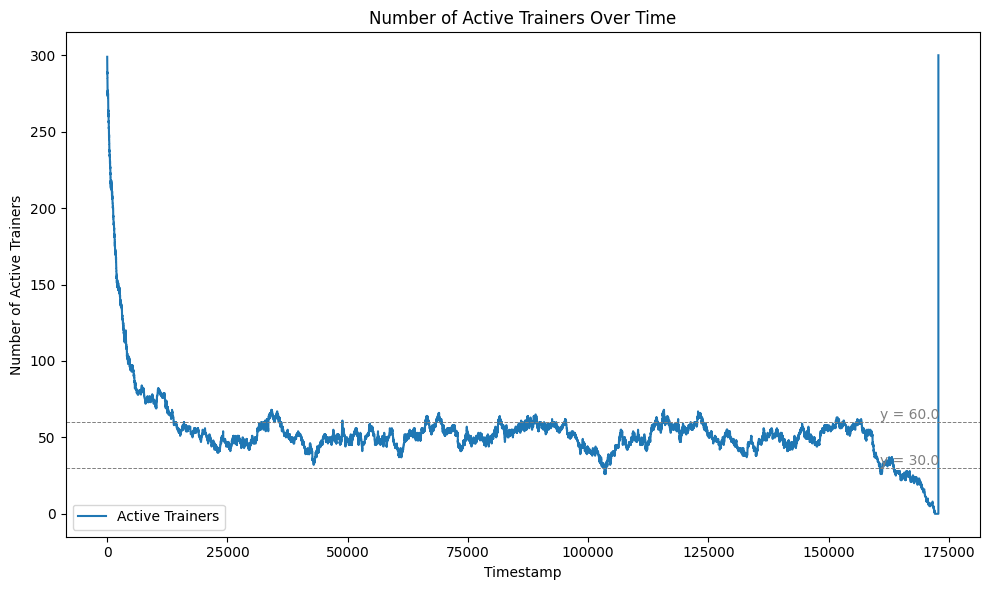

In [112]:
def plot_active_trainers(active_trainers_count, max_timestamp=EXPT_DURATION_S):
    # Plot the number of active trainers over time
    plt.figure(figsize=(10, 6))
    plt.plot(range(max_timestamp + 1), active_trainers_count, label='Active Trainers')
    
    # Add horizontal lines with labels at y = 10, y = 20
    for y_value in [0.1*NUM_CLIENTS, 0.2*NUM_CLIENTS]:
        plt.axhline(y=y_value, color='grey', linestyle='--', linewidth=0.7)
        plt.text(max_timestamp + 200, y_value, f'y = {y_value}', color='grey', 
                 verticalalignment='bottom', horizontalalignment='right')

    plt.xlabel('Timestamp')
    plt.ylabel('Number of Active Trainers')
    plt.title('Number of Active Trainers Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Calculate active trainers count
active_trainers_count = count_active_trainers(trainer_to_inactivity_dict)

# Plot the active trainers count
plot_active_trainers(active_trainers_count)

##### Fix the trainer avail duration (remove initial long period of >25% avail)

In [114]:
def find_first_low_trainer_index(active_trainers_count):
    if not active_trainers_count:
        return -1  # Return -1 if the list is empty
    
    threshold = 0.25 * active_trainers_count[0]  # Calculate 20% of the first value
    
    for index, count in enumerate(active_trainers_count):
        if count <= threshold:
            return index  # Return the first index where the condition is met
    
    return -1  # Return -1 if no such index is found

# NOTE: We remove upto the point where we have 100->20% availability
# dip. 
dipped_to_25_at_ts = find_first_low_trainer_index(active_trainers_count)
print("Dipped to < 25% percent avail at index", dipped_to_25_at_ts)

Dipped to < 25% percent avail at index 7876


#### Fix the trainer inactive durations using the index found above

In [115]:
import random

def update_inactivity_dict(trainer_to_inactivity_dict, index):
    updated_dict = {}
    
    for trainer_id, unavailability_list in trainer_to_inactivity_dict.items():
        # First pass: Remove elements where unavailability_start + unavailability_duration < index
        filtered_list = [
            (start, duration) for start, duration in unavailability_list 
            if start + duration >= index
        ]
        
        # Second pass: Subtract the index value from unavailability_start of each element
        # wherever start is greater than the index
        # If start < index, replace start by 30 which means that the
        # trainer will be alive for the first (30,300) seconds and then go
        # unavailable.
        updated_list = [
            ((start - index) if start > index else random.randint(30, 300), duration) for start, duration in filtered_list
        ]
        
        updated_dict[trainer_id] = updated_list
    
    return updated_dict

updated_trainer_inactivity_dict = update_inactivity_dict(trainer_to_inactivity_dict, dipped_to_25_at_ts)

In [123]:
def verify_and_find_min_value(updated_dict):
    min_value = float('inf')  # Initialize with positive infinity
    no_negative_values = True

    for trainer_id, unavailability_list in updated_dict.items():
        for start, duration in unavailability_list:
            if start < 0 or duration < 0:
                no_negative_values = False
            if start < min_value:
                min_value = start
            if duration < min_value:
                min_value = duration

    if no_negative_values:
        print("No negative values found.")
    else:
        print("Negative values found.")

    print(f"The minimum value across all values is: {min_value}")
    
    return no_negative_values, min_value

no_negatives, min_val = verify_and_find_min_value(updated_trainer_inactivity_dict)

No negative values found.
The minimum value across all values is: 1


In [116]:
trainer_to_inactivity_dict[1]

[(487, 11340),
 (15786, 13096),
 (34990, 13631),
 (49819, 1),
 (51395, 185),
 (52039, 538),
 (52669, 2703),
 (55379, 4),
 (66586, 14594),
 (87145, 30117),
 (117268, 1),
 (119203, 88),
 (119784, 2265),
 (122534, 135),
 (122687, 5),
 (122848, 14),
 (125937, 19243),
 (146590, 9),
 (154858, 9),
 (156394, 6072),
 (170682, 2118)]

In [124]:
updated_trainer_inactivity_dict[1]

[(284, 11340),
 (7910, 13096),
 (27114, 13631),
 (41943, 1),
 (43519, 185),
 (44163, 538),
 (44793, 2703),
 (47503, 4),
 (58710, 14594),
 (79269, 30117),
 (109392, 1),
 (111327, 88),
 (111908, 2265),
 (114658, 135),
 (114811, 5),
 (114972, 14),
 (118061, 19243),
 (138714, 9),
 (146982, 9),
 (148518, 6072),
 (162806, 2118)]

In [125]:
dipped_to_25_at_ts

7876

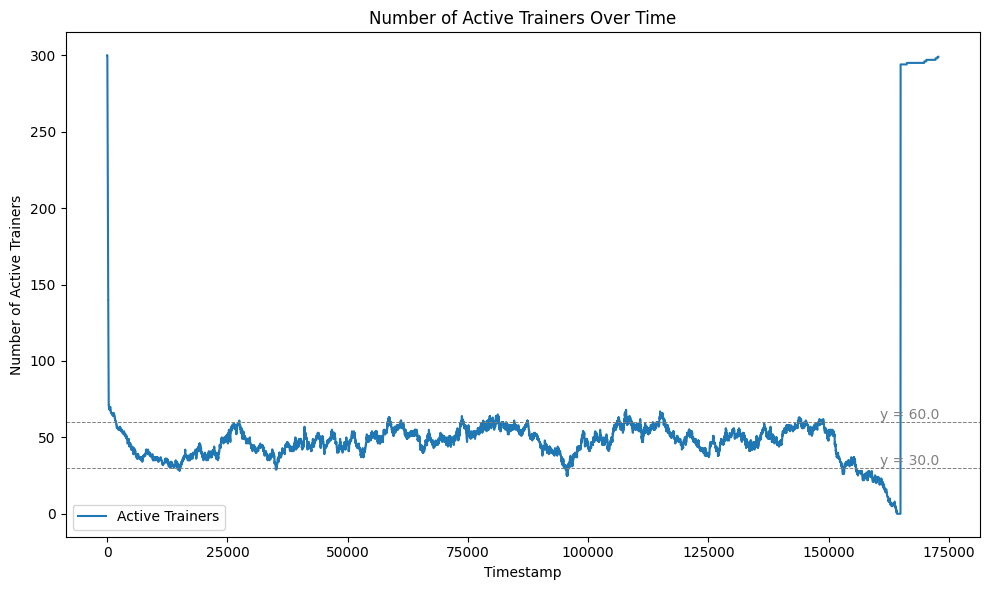

In [119]:
# Verify the new availability distribution
# Calculate active trainers count
active_trainers_count = count_active_trainers(updated_trainer_inactivity_dict)

# Plot the active trainers count
plot_active_trainers(active_trainers_count)

### Add the inactive durations to config files

In [126]:
def update_failure_durations(directory_path, trainer_to_inactivity_dict, noFail):
    """
    Update the 'failure_durations_s' property in each JSON file in the specified directory.

    Parameters:
    - directory_path (str): The path to the directory containing JSON files.
    - new_value (str): The new value for the 'failure_durations_s' property.

    Returns:
    - None
    """
    # Loop through all files in the directory
    trainer_counter = 1
    for filename in os.listdir(directory_path):
        if filename.endswith(".json") and filename.startswith("trainer_"):
            file_path = os.path.join(directory_path, filename)

            # Read the JSON file
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)

            # Add or update the "failure_durations_s" key in the "hyperparameters" dictionary
            hyperparameters = data.get("hyperparameters", {})
            if noFail == True:
                hyperparameters["failure_durations_s"] = str([])
            elif noFail == False:
                hyperparameters["failure_durations_s"] = str(trainer_to_inactivity_dict[trainer_counter])
            data["hyperparameters"] = hyperparameters

            # Write the modified data back to the JSON file
            with open(file_path, 'w') as json_file:
                json.dump(data, json_file, indent=2)

            print(f"Updated {filename}")
            trainer_counter += 1

    print("Update completed.")

In [127]:
# Replace with the actual path to your directory
directory_path = "config_dir100_num300_traceFail_48h"  
update_failure_durations(directory_path, updated_trainer_inactivity_dict, noFail=False)

# directory_path = "/Users/dhruv/Documents/Academics/Summer_23/Dist_training_fault_tolerance/expt_configs/config_dir1_num200_noFail"  # Replace with the actual path to your directory
# update_failure_durations(directory_path, trainer_to_inactivity_dict, True)

Updated trainer_244.json
Updated trainer_65.json
Updated trainer_77.json
Updated trainer_81.json
Updated trainer_284.json
Updated trainer_72.json
Updated trainer_258.json
Updated trainer_224.json
Updated trainer_236.json
Updated trainer_293.json
Updated trainer_40.json
Updated trainer_198.json
Updated trainer_216.json
Updated trainer_75.json
Updated trainer_168.json
Updated trainer_125.json
Updated trainer_290.json
Updated trainer_215.json
Updated trainer_207.json
Updated trainer_283.json
Updated trainer_78.json
Updated trainer_176.json
Updated trainer_174.json
Updated trainer_146.json
Updated trainer_19.json
Updated trainer_225.json
Updated trainer_169.json
Updated trainer_162.json
Updated trainer_246.json
Updated trainer_203.json
Updated trainer_232.json
Updated trainer_165.json
Updated trainer_229.json
Updated trainer_83.json
Updated trainer_89.json
Updated trainer_147.json
Updated trainer_245.json
Updated trainer_94.json
Updated trainer_28.json
Updated trainer_92.json
Updated train

In [69]:
trainer_to_inactivity_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [128]:
updated_trainer_inactivity_dict[245]

[(3496, 34018),
 (39490, 3252),
 (44089, 12869),
 (59231, 47154),
 (107894, 34648),
 (142564, 10),
 (145985, 1228),
 (151435, 13489)]

In [129]:
trainer_to_inactivity_dict[245]

[(11372, 34018),
 (47366, 3252),
 (51965, 12869),
 (67107, 47154),
 (115770, 34648),
 (150440, 10),
 (153861, 1228),
 (159311, 13489)]

### Incorporating the training delays

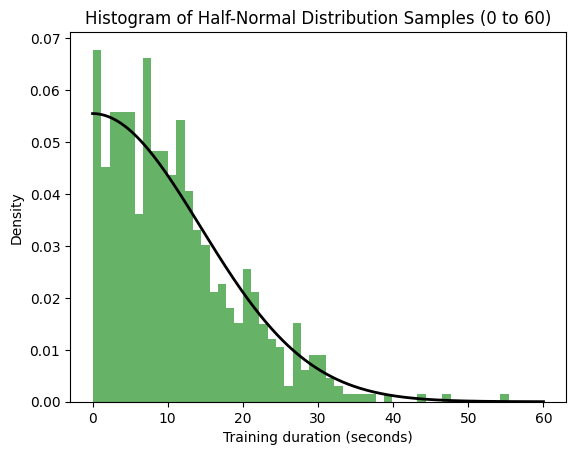

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import halfnorm

# Desired range
min_value = 0
max_value = 60

# Set the seed for reproducibility
np.random.seed(42)

# Calculate standard deviation for a normal distribution covering the range
std_dev = (max_value - min_value) / (2 * np.sqrt(2 * np.log(2)))

# Adjust the scale parameter for the half-normal distribution
scale = std_dev / np.sqrt(np.pi)

# Sample NUM_CLIENTS points from the adjusted half-normal distribution
samples = halfnorm.rvs(scale=scale, size=NUM_CLIENTS*2)

# Plot the histogram of the sampled data points
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')

# Plot the theoretical PDF for comparison
x = np.linspace(min_value, max_value, 1000)
pdf = halfnorm.pdf(x, scale=scale)
plt.plot(x, pdf, 'k', linewidth=2)

plt.title('Histogram of Half-Normal Distribution Samples (0 to 60)')
plt.xlabel('Training duration (seconds)')
plt.ylabel('Density')
plt.show()

In [138]:
std_dev

25.479654008640573

In [139]:
# samples generated are floating point nos. Convert them to ceil int
ceil_time_from_samples = np.ceil(samples)
ceil_time_from_samples

array([ 8.,  2., 10., 22.,  4.,  4., 23., 12.,  7.,  8.,  7.,  7.,  4.,
       28., 25.,  9., 15.,  5., 14., 21., 22.,  4.,  1., 21.,  8.,  2.,
       17.,  6.,  9.,  5.,  9., 27.,  1., 16., 12., 18.,  4., 29., 20.,
        3., 11.,  3.,  2.,  5., 22., 11.,  7., 16.,  5., 26.,  5.,  6.,
       10.,  9., 15., 14., 13.,  5.,  5., 15.,  7.,  3., 16., 18., 12.,
       20.,  2., 15.,  6., 10.,  6., 23.,  1., 23., 38., 12.,  2.,  5.,
        2., 29.,  4.,  6., 22.,  8., 12.,  8., 14.,  5.,  8.,  8.,  2.,
       14., 11.,  5.,  6., 22.,  5.,  4.,  1.,  4., 21.,  7.,  5., 12.,
        3.,  6., 28.,  3.,  4.,  2., 28.,  1.,  1., 36.,  3.,  5.,  1.,
       17., 17., 11., 12., 14., 21., 21.,  9., 32., 15.,  9.,  2.,  8.,
       23.,  1., 16.,  7., 14., 23., 12.,  5., 12., 18.,  4., 19., 24.,
        3.,  4., 12., 18., 19.,  8.,  5.,  4.,  5., 10.,  4.,  5., 11.,
       27.,  7., 18., 10., 15., 12., 17., 12., 14.,  6., 12., 28.,  4.,
       11., 13., 12.,  2.,  5.,  4., 12.,  1., 21.,  4., 40.,  9

In [140]:
# get avg runtime from samples. 
# NOTE: It will be used by new joining OORT trainers for their initial runtime.
np.mean(ceil_time_from_samples)

# 100 clients -> avg runtime 10.93s
# 1000 clients -> 11.7s
# 10000 clients -> 11.99 =======> Using this value of 12s since it will fit upto large num_clients

11.601666666666667

In [143]:
# NOTE: Need a runtime >= 2 seconds. So will drop all the 1 values
# fron the list
ceil_time_from_samples = ceil_time_from_samples[ceil_time_from_samples != 1]

print("Minimum delay duration is: ", min(ceil_time_from_samples))

Minimum delay duration is:  2.0


In [144]:
trainer_to_delay_s_dict = {}
for i in range(1, NUM_CLIENTS+1):
    trainer_to_delay_s_dict[i] = ceil_time_from_samples[i-1]

In [145]:
def update_delay_durations(directory_path, trainer_to_delay_s_dict):
    """
    Update the 'delay_durations_s' property in each JSON file in the specified directory.

    Parameters:
    - directory_path (str): The path to the directory containing JSON files.
    - new_value (str): The new value for the 'failure_durations_s' property.

    Returns:
    - None
    """
    # Loop through all files in the directory
    trainer_counter = 1
    for filename in os.listdir(directory_path):
        if filename.endswith(".json") and filename.startswith("trainer_"):
            file_path = os.path.join(directory_path, filename)

            # Read the JSON file
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)

            # Add or update the "failure_durations_s" key in the "hyperparameters" dictionary
            hyperparameters = data.get("hyperparameters", {})
            hyperparameters["training_delay_s"] = str(trainer_to_delay_s_dict[trainer_counter])
            data["hyperparameters"] = hyperparameters

            # Write the modified data back to the JSON file
            with open(file_path, 'w') as json_file:
                json.dump(data, json_file, indent=2)

            print(f"Updated {filename}")
            trainer_counter += 1

    print("Update completed.")

In [146]:
# Replace with the actual path to your directory

directory_path = "config_dir100_num300_traceFail_48h"
update_delay_durations(directory_path, trainer_to_delay_s_dict)

Updated trainer_244.json
Updated trainer_65.json
Updated trainer_77.json
Updated trainer_81.json
Updated trainer_284.json
Updated trainer_72.json
Updated trainer_258.json
Updated trainer_224.json
Updated trainer_236.json
Updated trainer_293.json
Updated trainer_40.json
Updated trainer_198.json
Updated trainer_216.json
Updated trainer_75.json
Updated trainer_168.json
Updated trainer_125.json
Updated trainer_290.json
Updated trainer_215.json
Updated trainer_207.json
Updated trainer_283.json
Updated trainer_78.json
Updated trainer_176.json
Updated trainer_174.json
Updated trainer_146.json
Updated trainer_19.json
Updated trainer_225.json
Updated trainer_169.json
Updated trainer_162.json
Updated trainer_246.json
Updated trainer_203.json
Updated trainer_232.json
Updated trainer_165.json
Updated trainer_229.json
Updated trainer_83.json
Updated trainer_89.json
Updated trainer_147.json
Updated trainer_245.json
Updated trainer_94.json
Updated trainer_28.json
Updated trainer_92.json
Updated train

In [147]:
trainer_to_delay_s_dict

{1: 8.0,
 2: 2.0,
 3: 10.0,
 4: 22.0,
 5: 4.0,
 6: 4.0,
 7: 23.0,
 8: 12.0,
 9: 7.0,
 10: 8.0,
 11: 7.0,
 12: 7.0,
 13: 4.0,
 14: 28.0,
 15: 25.0,
 16: 9.0,
 17: 15.0,
 18: 5.0,
 19: 14.0,
 20: 21.0,
 21: 22.0,
 22: 4.0,
 23: 21.0,
 24: 8.0,
 25: 2.0,
 26: 17.0,
 27: 6.0,
 28: 9.0,
 29: 5.0,
 30: 9.0,
 31: 27.0,
 32: 16.0,
 33: 12.0,
 34: 18.0,
 35: 4.0,
 36: 29.0,
 37: 20.0,
 38: 3.0,
 39: 11.0,
 40: 3.0,
 41: 2.0,
 42: 5.0,
 43: 22.0,
 44: 11.0,
 45: 7.0,
 46: 16.0,
 47: 5.0,
 48: 26.0,
 49: 5.0,
 50: 6.0,
 51: 10.0,
 52: 9.0,
 53: 15.0,
 54: 14.0,
 55: 13.0,
 56: 5.0,
 57: 5.0,
 58: 15.0,
 59: 7.0,
 60: 3.0,
 61: 16.0,
 62: 18.0,
 63: 12.0,
 64: 20.0,
 65: 2.0,
 66: 15.0,
 67: 6.0,
 68: 10.0,
 69: 6.0,
 70: 23.0,
 71: 23.0,
 72: 38.0,
 73: 12.0,
 74: 2.0,
 75: 5.0,
 76: 2.0,
 77: 29.0,
 78: 4.0,
 79: 6.0,
 80: 22.0,
 81: 8.0,
 82: 12.0,
 83: 8.0,
 84: 14.0,
 85: 5.0,
 86: 8.0,
 87: 8.0,
 88: 2.0,
 89: 14.0,
 90: 11.0,
 91: 5.0,
 92: 6.0,
 93: 22.0,
 94: 5.0,
 95: 4.0,
 96: 4.0,
 97:

#### MISC change to replicate one files trainer id, failure durations from a file into another dir

In [54]:
import json
import os

def update_trainer_configs(source_dir, target_dir, num_trainers=100):
    # Iterate over the number of trainers
    for i in range(1, num_trainers + 1):
        source_file_path = os.path.join(source_dir, f'trainer_{i}.json')
        target_file_path = os.path.join(target_dir, f'trainer_{i}.json')

        # Read the source JSON file
        with open(source_file_path, 'r') as source_file:
            source_data = json.load(source_file)

        # Read the target JSON file
        with open(target_file_path, 'r') as target_file:
            target_data = json.load(target_file)

        # Update the target JSON file with values from the source JSON file
        target_data['taskid'] = source_data['taskid']

        target_data['hyperparameters']['failure_durations_s'] = source_data['hyperparameters']['failure_durations_s']
        
        target_data['hyperparameters']['training_delay_s'] = source_data['hyperparameters']['training_delay_s']

        # Write the updated configuration back to the target file
        with open(target_file_path, 'w') as target_file:
            json.dump(target_data, target_file, indent=4)

In [156]:
# Example usage
source_dir = 'config_dir100_num300_traceFail_48h'
target_dir = 'config_dir0.1_num300_traceFail_48h'
update_trainer_configs(source_dir, target_dir)

## DATASET 2: CIFAR-10

In [4]:
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import json
import math

from fedlab.utils.dataset.partition import CIFAR10Partitioner
from fedlab.utils.functional import partition_report

# num_clients = 10
NUM_CLIENTS = 300

num_classes = 10
seed = 2021
hist_color = '#4169E1'

In [7]:
trainset = torchvision.datasets.CIFAR10(
    root="/home/dgarg39/cifar_data/data/CIFAR10/",
    train=True,
    download=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 34585462.68it/s]


Extracting /home/dgarg39/cifar_data/data/CIFAR10/cifar-10-python.tar.gz to /home/dgarg39/cifar_data/data/CIFAR10/


##### Functions to create and return client_dicts

In [12]:
# def genHeteroDirPartitions(trainset_targets, num_clients, balance, partition, dir_alpha, seed, num_classes, dir_name):
#     hetero_dir_part = CIFAR10Partitioner(trainset_targets,
#                                          num_clients,
#                                          balance=balance,
#                                          partition=partition,
#                                          dir_alpha=dir_alpha,
#                                          seed=seed)
    
#     csv_file = "/home/dgarg39/cifar_data/cifar10_partitioning/partition_reports/cifar10_hetero_dir_" + str(dir_alpha) + "_" + str(num_clients) + "clients.csv"
#     partition_report(trainset_targets, hetero_dir_part.client_dict,
#                      class_num=num_classes,
#                      verbose=False, file=csv_file)
    
#     hetero_dir_part_df = pd.read_csv(csv_file,header=1)
#     hetero_dir_part_df = hetero_dir_part_df.set_index('client')
#     col_names = [f"class{i}" for i in range(num_classes)]
#     for col in col_names:
#         hetero_dir_part_df[col] = (hetero_dir_part_df[col] * hetero_dir_part_df['Amount']).astype(int)
        
#     hetero_dir_part_df[col_names].iloc[:10].plot.barh(stacked=True)
#     plt.tight_layout()
#     plt.xlabel('sample num')
#     plt.savefig(f"/home/dgarg39/cifar_data/cifar10_partitioning/imgs/cifar10_hetero_dir_" + str(dir_alpha) + "_" + str(num_clients) + "clients.png", dpi=400)
    
#     return hetero_dir_part.client_dict

In [28]:
# NOTE: NOT USED since it was taking too long for alpha=0.1 value

# hetero_dir_part_client_dict = genHeteroDirPartitions(
#     trainset_targets = trainset.targets,
#     num_clients = NUM_CLIENTS,
#     balance = None,
#     partition = "dirichlet",
#     dir_alpha = 0.1,
#     seed = seed,
#     num_classes = num_classes,
#     dir_name = "hetero_dirichlet")

KeyboardInterrupt: 

In [38]:
def create_dirichlet_splits_cifar(dataset: Dataset, num_trainers: int, alpha: float) -> dict:
    """
    Create splits of dataset indices according to a Dirichlet distribution.

    Args:
        dataset (Dataset): The dataset to split.
        num_trainers (int): The number of trainers.
        alpha (float): The alpha value for the Dirichlet distribution.

    Returns:
        dict: A dictionary mapping each trainer ID to a list of dataset indices.
    """
    labels = [label for _, label in dataset]  # Assuming the third element is the label
    # labels = np.array([LABEL_MAP[label] for label in labels])  # Convert labels to integers
    
    num_classes = len(np.unique(labels))
    label_distribution = defaultdict(list)

    # Collect indices for each class
    for idx, label in enumerate(labels):
        label_distribution[label].append(idx)

    # Create Dirichlet distribution splits
    trainer_indices = defaultdict(list)
    for label, indices in label_distribution.items():
        proportions = np.random.dirichlet([alpha] * num_trainers)
        proportions = (proportions * len(indices)).astype(int)
        np.random.shuffle(indices)
        start_idx = 0
        for i, count in enumerate(proportions):
            trainer_indices[i].extend(indices[start_idx:start_idx + count])
            start_idx += count

    return trainer_indices

In [50]:
if __name__ == "__main__":
    dataset = torchvision.datasets.CIFAR10(
    root="/home/dgarg39/cifar_data/data/CIFAR10/",
    train=True,
    download=True)
    num_trainers = 300
    alpha = 100
    trainer_indices = create_dirichlet_splits_cifar(dataset, num_trainers, alpha)
    print(trainer_indices)

Files already downloaded and verified
defaultdict(<class 'list'>, {0: [32074, 44650, 17925, 28690, 13956, 11110, 1126, 20021, 11246, 30249, 20027, 807, 38310, 34447, 16488, 38494, 35498, 29438, 14083, 42140, 45593, 21406, 43311, 35043, 5320, 29990, 28285, 19840, 39522, 49611, 34427, 9425, 2450, 1451, 2461, 28160, 12453, 39209, 21191, 17992, 8732, 49575, 44900, 41441, 22963, 7097, 15917, 36648, 18671, 15386, 49411, 5769, 27130, 13722, 10912, 48917, 42834, 1724, 20199, 7640, 41133, 23088, 24018, 24739, 48493, 16053, 15285, 33137, 28545, 21778, 40961, 36598, 13752, 13770, 3019, 15654, 3226, 35350, 37549, 8555, 22871, 39949, 33825, 29355, 33388, 43656, 6076, 46270, 39181, 23098, 41438, 29387, 9207, 37636, 17822, 34591, 92, 11948, 32203, 45386, 45062, 42497, 14141, 46582, 21432, 34641, 11244, 14208, 12115, 11898, 47373, 46435, 8672, 49591, 15676, 18960, 33355, 25259, 16635, 36273, 30880, 14032, 22922, 20194, 22891, 7224, 45075, 31912, 34935, 17780, 26179, 8691, 3502, 32255, 41406, 42731, 45

In [35]:
dataset[1]

(<PIL.Image.Image image mode=RGB size=32x32>, 9)

In [51]:
### CREATING new json files with these indices using a previously implemented function
# Example usage
base_config_path = './async_cifar10/trainer/config_dir100_num300_traceFail_48h/base_config.json'
output_dir = './async_cifar10/trainer/config_dir100_num300_traceFail_48h'


# NOTE: THIS WILL CREATE NEW CONFIGS. 
# ###### DO THIS ONLY IF TRAINER DOESNT EXIST. IF IT DOES, IT WILL BE OVERWRITTEN

create_trainer_configs(
    base_config_path,
    trainer_indices=trainer_indices,
    output_dir=output_dir,
    num_trainers=300)

Updated trainer_1.json
Updated trainer_2.json
Updated trainer_3.json
Updated trainer_4.json
Updated trainer_5.json
Updated trainer_6.json
Updated trainer_7.json
Updated trainer_8.json
Updated trainer_9.json
Updated trainer_10.json
Updated trainer_11.json
Updated trainer_12.json
Updated trainer_13.json
Updated trainer_14.json
Updated trainer_15.json
Updated trainer_16.json
Updated trainer_17.json
Updated trainer_18.json
Updated trainer_19.json
Updated trainer_20.json
Updated trainer_21.json
Updated trainer_22.json
Updated trainer_23.json
Updated trainer_24.json
Updated trainer_25.json
Updated trainer_26.json
Updated trainer_27.json
Updated trainer_28.json
Updated trainer_29.json
Updated trainer_30.json
Updated trainer_31.json
Updated trainer_32.json
Updated trainer_33.json
Updated trainer_34.json
Updated trainer_35.json
Updated trainer_36.json
Updated trainer_37.json
Updated trainer_38.json
Updated trainer_39.json
Updated trainer_40.json
Updated trainer_41.json
Updated trainer_42.json
U

In [53]:
len(trainer_indices[240])

159

In [58]:
# Final version of taskid, trainer unavail durations, trainer delays
# for N=300 before SoCC deadline was done for async_google_speech. Use
# those same configs for cifar-10 too.

source_dir = 'async_google_speech/trainer/config_dir100_num300_traceFail_48h'
target_dir = 'async_cifar10/trainer/config_dir100_num300_traceFail_48h'
update_trainer_configs(source_dir, target_dir)